In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit
from qiskit.primitives import BackendEstimator
#from qiskit_ibm_runtime import QiskitRuntimeService
 
# Load saved credentials
#service = QiskitRuntimeService()


In [2]:
#Defined the graphs in the seperate file
from graph import G_set, coordinate_list

# Graphs defined

The following graphs are defined for this problem. The reasoning is compatibility with a straightforward mapping using Rydberg blockade in Part 2. Where, we can place these nodes on a square lattice and an edge occurs only when two nodes are within Rydberg blockade distance with each other. 

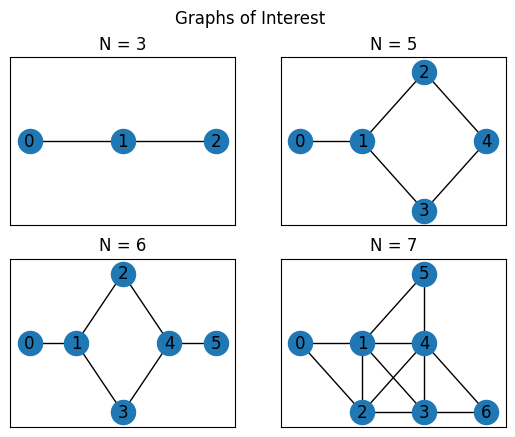

In [18]:
fig,axs = plt.subplots(2,2)
for i,ax in enumerate(fig.axes):
    pos = coordinate_list[i]
    nx.draw_networkx(G_set[i], pos, ax = ax)
    ax.set_title("N = {}".format(len(G_set[i].nodes())))
fig.suptitle("Graphs of Interest")
plt.show()

### Cost Hamiltonian Formualtion for QAOA
For a graph $G = (V,E)$, with n vertices, V = $\{ v_1, v_2, v_3 ... v_n \}$, and m edges, E = $\{ e_1, e_2, e_3 ... e_m \}$, also for each edge $e_k \in E$, we define $e_k = (v_i,v_j)$ where $v_i, v_j \in V$. Since our graphs are undirected, the ordering does not matter. Each vertices represent a qubit, with $X_{i} \in \{0,1\}, \forall i \in n$. We have the coefficients, $J, h > 0$, 


\begin{equation}
H_c = \sum_{(v_i,v_j) \in E} J X_{v_i}^z X_{v_j}^z - \sum_{v_j \in V} h X_{v_j}^z
\end{equation}

We want to map $X_i$ to our Pauli-Z operators, using $X_i = \frac{1-\sigma^Z_{i}}{2}$ as our mapping from the range $\{0,1\}$ to $\{1,-1\}$. Hence, the Hamiltonian that we want to implement now becomes

\begin{align}
H_c &= J \sum_{(v_i,v_j) \in E}  \frac{1-\sigma^Z_{v_i}}{2} \frac{1-\sigma^Z_{v_j}}{2} - h \sum_{v_j \in V}  \frac{1-\sigma^Z_{i}}{2} \\
&= J \sum_{(v_i,v_j) \in E}  \frac{1 - \sigma^Z_{i} - \sigma^Z_{j} + \sigma^Z_{i}\sigma^Z_{j} }{4} - h \sum_{v_j \in V}  \frac{1-\sigma^Z_{i}}{2} \\
&= \frac{J}{4} \sum_{(v_i,v_j) \in E} \sigma^Z_{i}\sigma^Z_{j} - \frac{J}{4} \sum_{(v_i,v_j) \in E} (\sigma^Z_{i} + \sigma^Z_{j}) +  \frac{h}{2} \sum_{v_j \in V}  \sigma^Z_{j} \\
\end{align}

In the last step, constant terms were ignored, and we only focus on the operators. Given this construction, we see that while we can easily implement $RZZ$ gates proportional to $\frac{J}{4}$, but to accurately implement the $RZ$ part, we could compute the angles needed on each qubit depending on the sums of several $-\frac{J}{4}$ terms and one $h$ term depending on graph topology.

To minimze this Hamiltonian, ideally we should have $J > h$, as any constraint violation is undesriable, and only when constraints are satisfied, we might want to optimize for more $|1>$ states. For now a guesstimate might be to set $J = 7$ and $h = 3$. We probably want J > 2h, since we want the |1>|1> configuration to be penalized with a positive energy of $J - 2h = 1$, while the |1>|0> configuration between two edges provide a $-h = -3$ energy. Of course, this is an estimate as some higher connected nodes might influence this heuristic based on its importance in the topology. 

Our mixing Hamiltonian, as per the original paper, will similarily be Pauli-X rotations, parametized by $\beta$

\begin{equation}
H_c = \sum_{v_i \in V} \sigma^{X}_{v_i}
\end{equation}

For the purpose of this challenge, 2-layers were chosen so it is feasible to run on hardwares available to me. 

In [19]:
#CONSTANTS
J = 7
h = 3
#Implicitly, two layers of QAOA, represented later as 2 gamma and beta values
p = 2

Here we have our objective function, which returns the hamiltonian and the value to the MIS problem, as well as whether a candidate solution is valid or not. Note here we use an indexing from left to right, with the bitstring mapping to the edges as $V_0 V_1 \cdots V_n$, this is in contrarary to how qiskit will present the results later, which employs a right to left counting system. 

In [20]:
def MIS_obj(x, G):
    '''
    Given a bitstring as a solution, return if this is a valid solution to the MIS problem, and the cardinality of the set
    Args:
        x: str
            solution bitstring, same length as nodes in G
        G: network x graph
    Returns:
        validity: Bool
            Whether solution is valid
        energy_value: float
            MIS Hamiltonian
        obj: int
            Objective value of the MIS problem -- cardinality of independent set
    '''
    if len(G.nodes) != len(x):
        raise Exception("Solution Bitstring is not the same length as Graph, try again!")
    
    validity = True 
    obj = 0
    

    sols = [bool(int(i)) for i in x]
    #Check if set is independent
    for v_i,v_j in G.edges:
        if (sols[v_i] and sols[v_j]) == True:
            validity = False
    #If it is, count again, if invalid, objective value is 0
    if validity == True: obj = np.sum(sols)
    #Compute the Hamiltonian
    energy_value = 0
    for v_i,v_j in G.edges:
        energy_value += J * sols[v_i] * sols[v_j]
    for v_i in G.nodes:
        energy_value += -h * sols[v_i]

    return validity,obj, energy_value

In [21]:
# Input, a network x Graph
def create_qc(beta, gamma, G):
    """
    Create a QAOA circuit parametized by beta and gamma for solving the MIS problem on a graph G

    Input:
        beta: list of floats
            set of parameters for the mixing hamiltonian
        gamma: list of floats
            set of parameters for the cost hamiltonian
        G: network X graph
            problem of interest
    Output;
        G: network X graph
        qc: qiskit.QuantumCircuit
            QAOA circuit to be ran and measured
    """
    num_layer = len(beta)
    graph_size = len(G.nodes)
    # Output, quantum circuit
    qc = QuantumCircuit(graph_size)
    # Initial: Hadamarding
    qc.h(range(graph_size))
    # Create H_C: Cost Hamiltonian, in P_Z basis, rotate parametized by gamma
    for i, layer in enumerate(range(num_layer)):
        #Implement H_C -- cost hamiltonian
        degree_count = np.zeros(len(G.nodes))
        for v_i,v_j in G.edges:
            qc.rzz(J*gamma[i]/4,v_i,v_j)
            degree_count[v_i] += 1
            degree_count[v_j] += 1
        for v_i in G.nodes:
            qc.rz(gamma[i]*(h/2 - J/4*degree_count[v_i]), v_i)
        #Implement H_B -- mixing hamiltonian
        for v_j in G.edges:
            qc.rx(2*beta[i], v_j)
    qc.measure_all()
    return G,qc
G,qc = create_qc([1,1],[1,1],G_set[1])
#Example Circuit
qc.draw()

┌───┐           ┌───────────┐ ┌───────┐                         »
   q_0: ┤ H ├─■─────────┤ Rz(-0.25) ├─┤ Rx(2) ├─────────────────────────»
        ├───┤ │ZZ(1.75) └───────────┘ └───────┘ ┌───────────┐ ┌───────┐ »
   q_1: ┤ H ├─■───────────■───────────■─────────┤ Rz(-3.75) ├─┤ Rx(2) ├─»
        ├───┤             │ZZ(1.75)   │         └───────────┘ ├───────┴┐»
   q_2: ┤ H ├─────────────■───────────┼───────────■───────────┤ Rz(-2) ├»
        ├───┤                         │ZZ(1.75)   │           └────────┘»
   q_3: ┤ H ├─────────────────────────■───────────┼───────────■─────────»
        ├───┤                                     │ZZ(1.75)   │ZZ(1.75) »
   q_4: ┤ H ├─────────────────────────────────────■───────────■─────────»
        └───┘                                                           »
meas: 5/════════════════════════════════════════════════════════════════»
                                                                        »
«                                      ┌───────────┐ ┌───────┐              »
«   q_0: ────────────────────■─────────┤ Rz(-0.25) ├─┤ Rx(2) ├──────────────»
«        ┌───────┐ ┌───────┐ │ZZ(1.75) └───────────┘ └───────┘ ┌───────────┐»
«   q_1: ┤ Rx(2) ├─┤ Rx(2) ├─■───────────■───────────■─────────┤ Rz(-3.75) ├»
«        ├───────┤ ├───────┤             │ZZ(1.75)   │         └───────────┘»
«   q_2: ┤ Rx(2) ├─┤ Rx(2) ├─────────────■───────────┼───────────■──────────»
«        ├───────┴┐├───────┤ ┌───────┐               │ZZ(1.75)   │          »
«   q_3: ┤ Rz(-2) ├┤ Rx(2) ├─┤ Rx(2) ├───────────────■───────────┼──────────»
«        ├────────┤├───────┤ ├───────┤                           │ZZ(1.75)  »
«   q_4: ┤ Rz(-2) ├┤ Rx(2) ├─┤ Rx(2) ├───────────────────────────■──────────»
«        └────────┘└───────┘ └───────┘                                      »
«meas: 5/═══════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                ░ ┌─┐            
«   q_0: ────────────────────────────────────────░─┤M├────────────
«         ┌───────┐ ┌───────┐ ┌───────┐          ░ └╥┘┌─┐         
«   q_1: ─┤ Rx(2) ├─┤ Rx(2) ├─┤ Rx(2) ├──────────░──╫─┤M├─────────
«         ├───────┴┐├───────┤ ├───────┤          ░  ║ └╥┘┌─┐      
«   q_2: ─┤ Rz(-2) ├┤ Rx(2) ├─┤ Rx(2) ├──────────░──╫──╫─┤M├──────
«         └────────┘├───────┴┐├───────┤┌───────┐ ░  ║  ║ └╥┘┌─┐   
«   q_3: ─■─────────┤ Rz(-2) ├┤ Rx(2) ├┤ Rx(2) ├─░──╫──╫──╫─┤M├───
«         │ZZ(1.75) ├────────┤├───────┤├───────┤ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ─■─────────┤ Rz(-2) ├┤ Rx(2) ├┤ Rx(2) ├─░──╫──╫──╫──╫─┤M├
«                   └────────┘└───────┘└───────┘ ░  ║  ║  ║  ║ └╥┘
«meas: 5/═══════════════════════════════════════════╩══╩══╩══╩══╩═
«                                                   0  1  2  3  4

In [22]:
from qiskit.primitives import Sampler

def run_circuit(qc):
    #Run the quantum circuit, sample and process solutions
    job = Sampler().run(qc)
    result = job.result()
    solutions = [q.binary_probabilities() for q in result.quasi_dists]
    probs = np.array(list(solutions[0].values()))
    hamiltonian = []
    validity_vals = []
    obj_vals = []
    #evaluate solution, validity, hamiltonian and MIS value
    for i in solutions[0].keys():
        i_flipped = i[::-1]
        validity,obj, energy_value = MIS_obj(i_flipped, G)
        hamiltonian.append(energy_value)
        validity_vals.append(validity)
        obj_vals.append(obj)
    
    expected_H_c = np.dot(np.array(hamiltonian),probs)

    return {"expected_hamiltonian": expected_H_c, 
            "measurment outcomes": solutions,
            "objective_values": obj_vals,
            "validity_values": validity_vals }

def get_expected_energy(beta,gamma,G):
    G,qc = create_qc(beta,gamma, G)
    output = run_circuit(qc)
    return output["expected_hamiltonian"]

#Quick sanity check, random gamma and betas
get_expected_energy([0.5,0.6],[0.4,0.5], G_set[1])

-0.8566040984694849

## QAOA Results

Here we obtain some preliminary results from the QAOA algorithm. We observe from the hamming weight that the highest probability solution is not always the MIS solution. Nevertheless, across the instances the highest probablity solution is a valid solution, which points to the circuit somewhat working. The plotting is restrcited to the top 20 probable statevectors as having 2^7 bars in one graph will certainly be too much to view.

Highest Probability Solution for Graph with 3 is 101 (True, 2, -6)


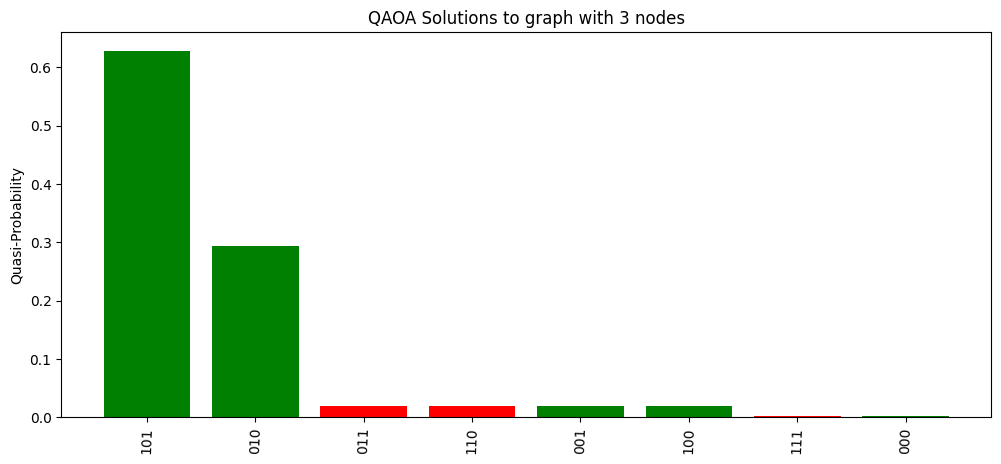

Highest Probability Solution for Graph with 5 is 10001 (True, 2, -6)


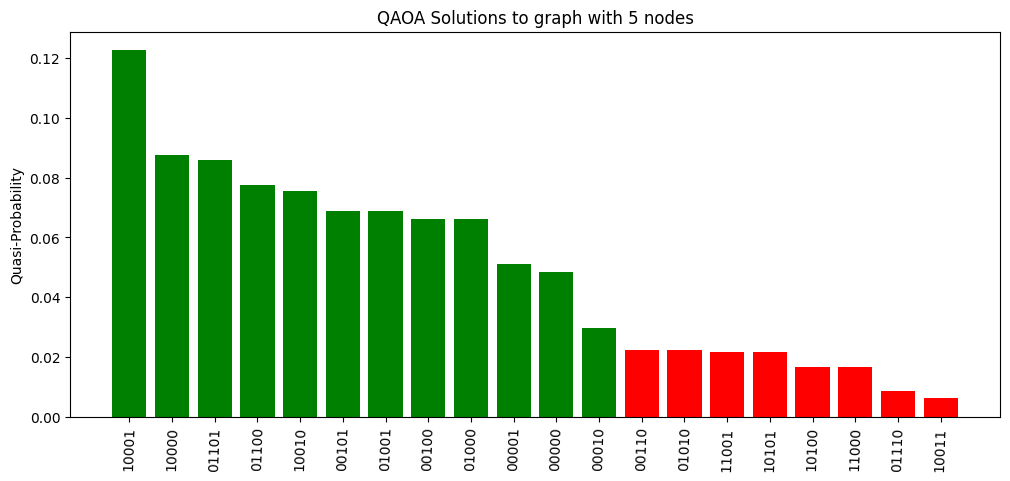

Highest Probability Solution for Graph with 6 is 101101 (True, 4, -12)


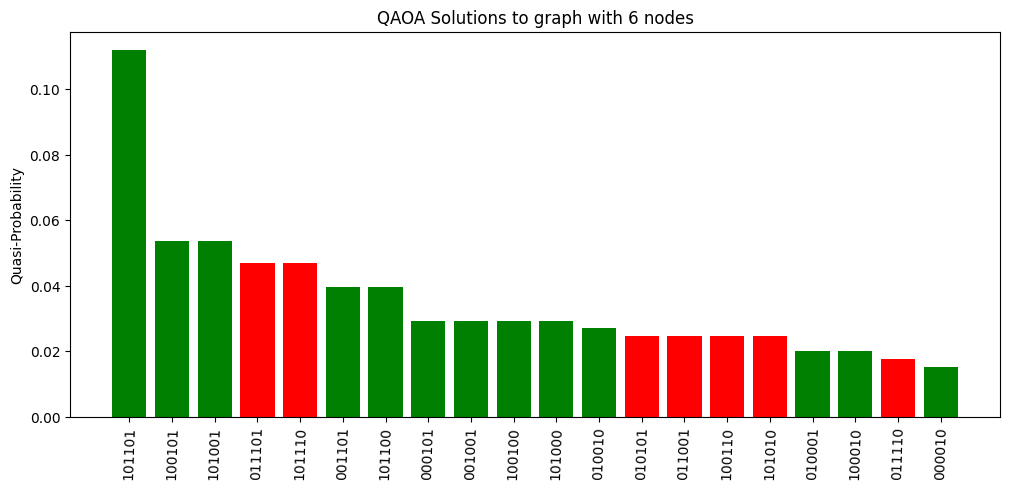

Highest Probability Solution for Graph with 7 is 1000011 (True, 3, -9)


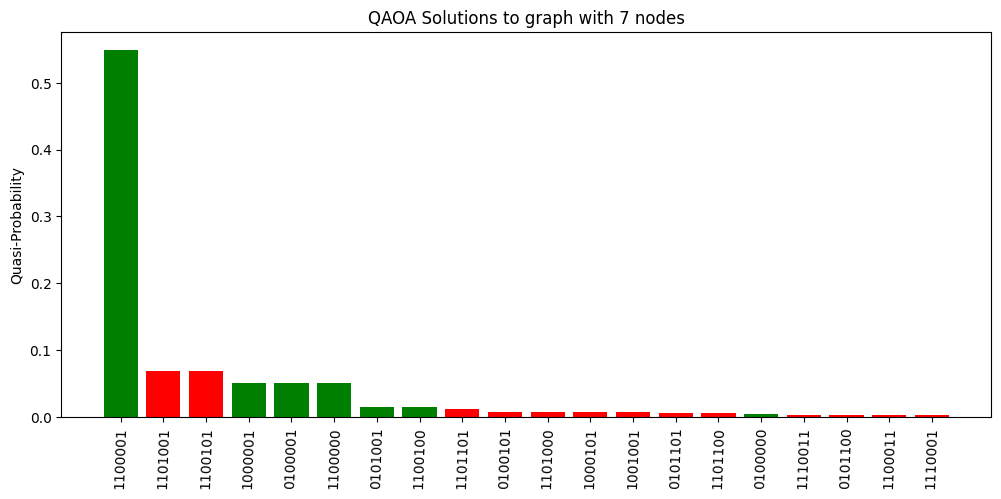

In [8]:
import matplotlib.pyplot as plt
import scipy.optimize
from math import pi
QAOA_results = []
for G in G_set:
        #Step 1: For each graph, optimize gamma and beta using SLSQP
        res = scipy.optimize.minimize(
                lambda x: get_expected_energy([x[0],x[1]],[x[2],x[3]],G),x0 = (0.3,0.2,0.4,0.1),
                method='SLSQP', bounds=[(0,pi),(0,pi),(0,2*pi),(0,2*pi)],options =  {"ftol" : 1e-11,"eps": 1e-8})
        G,qc = create_qc(res.x[0:2],res.x[2:4],G)
        output = run_circuit(qc)

        #Step 2: Gather Results
        sorted_solution = sorted((output['measurment outcomes'][0].items()), key=lambda x:x[1], reverse = True)
        x_values, y_values = zip(*sorted_solution)
        optimal_solution = sorted_solution[0][0]
        print("Highest Probability Solution for Graph with {} is {}".format(len(G.nodes()), sorted_solution[0][0][::-1]),MIS_obj(optimal_solution[::-1],G))
        
        #Step 3: Plot Results
        plt.figure(figsize= (12,5))
        values_to_show = min(20, len(x_values))
        sorted_validity = [MIS_obj(x_value[::-1],G)[0] for x_value in x_values]
        plt.bar(x_values[0:values_to_show],y_values[0:values_to_show],
                color = ["green" if val == True else "red" for val in sorted_validity] )
        plt.xticks(rotation = 88)
        plt.ylabel("Quasi-Probability")
        plt.title("QAOA Solutions to graph with {} nodes".format(len(G.nodes)))
        plt.show()

        #Saving results for comparison with Analogue
        QAOA_results.append(output)


# Analogue MIS using Rydberg Blockade 

We can model the MIS problem more straightforwardly using the Rydberg bloackade effect, where two atoms within the Rydberg radius cannot both enter the excited state. The graphs we have chosen provides an easy mapping to physically encode the problem. Where edges are only shared between an atom's neighbors in a square lattice formation, and we ensure that the diagonal and adjacant distances are some factors less than the Rydberg radius between two atoms. 

Implementing a minimally viable example from Pulser's documentation, we can create the following examples to implement the adiabetic evolution of the Hamiltonian as follows

\begin{equation}
H_{MIS} = \sum_{i} \frac{\hbar \Omega(t)}{2} \sigma^X_i - \sum_{i} \frac{\hbar \delta(t)}{2} \sigma^Z_i + \sum_{j < i} \frac{C_6}{|r_i - r_j|^6} n_i n_j
\end{equation}

Where $C_6$ is the interaction coefficient between atoms $i$ and $j$. We continuously vary the parameters of $\Omega$ and $\delta$ as part of the adiabatic evolution that will hopefully lead us to the ground state of $H_{MIS}$, with good solutions to the problem. 

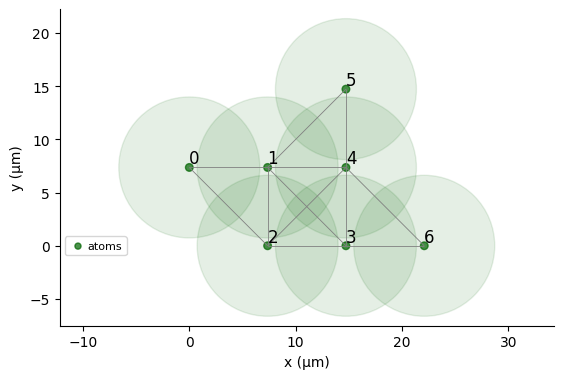

In [9]:
import pulser
from pulser import DigitalAnalogDevice, Register, Pulse, Sequence
from pulser_simulation import QutipEmulator
from pulser.waveforms import InterpolatedWaveform
#Example Atom Arrange to the graph n = 7
i = 3
scale = DigitalAnalogDevice.rydberg_blockade_radius(1.0)/1.8
coords_scaled = [(i*scale,j*scale) for (i,j) in coordinate_list[i]]
qubits = dict(enumerate(coords_scaled))
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [10]:
# We choose a median value between the min and the max
Omega = 4
delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

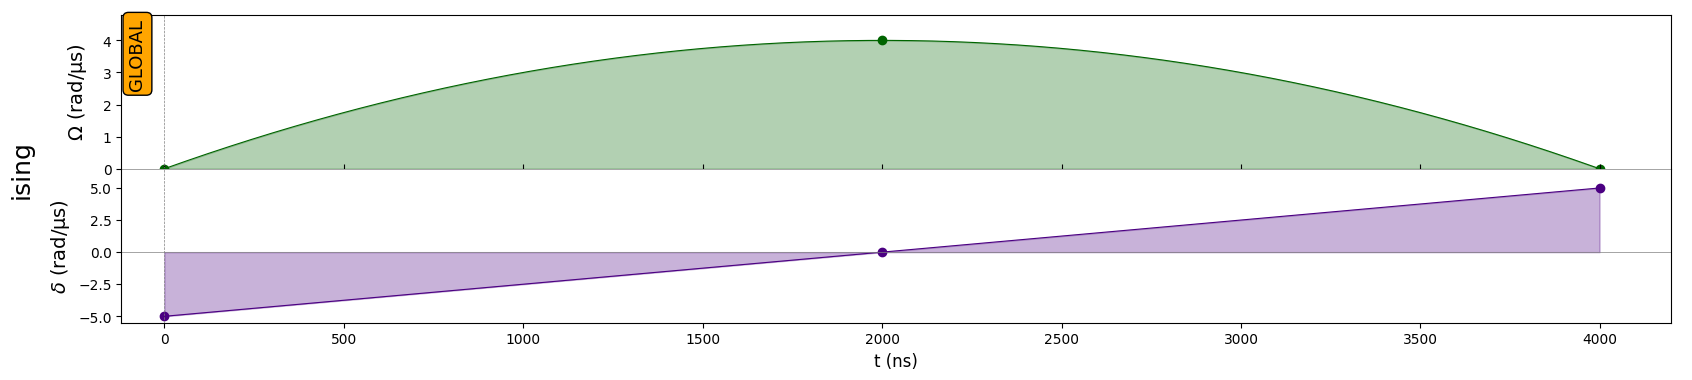

In [11]:
#Create Pulse sequence, using default setting found
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

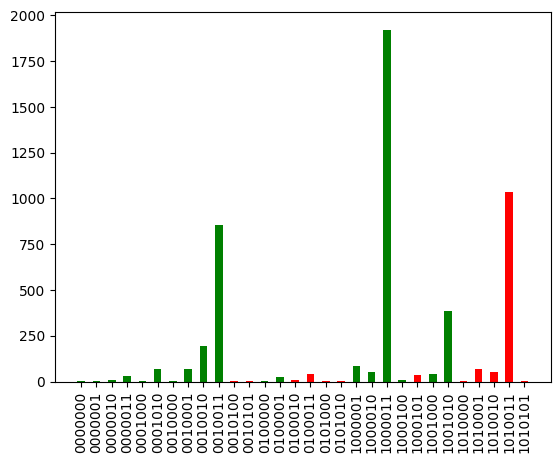

In [12]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples= 5000)
validity = [MIS_obj(sol,G_set[i])[0] for sol in list(count_dict.keys())]
plt.bar(count_dict.keys(), count_dict.values(),
        color = ["Green" if val == True else "Red" for val in validity],
        width=0.5)
plt.xticks(rotation="vertical")
plt.show()

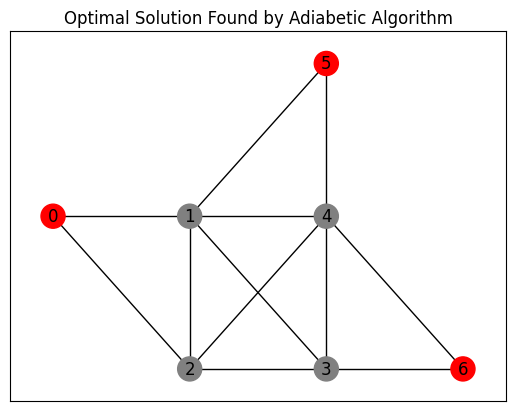

In [13]:
#Example demostration of optimal solution found
solutions_sorted = sorted(count_dict.items(), key = lambda x: x[1], reverse= True)
best_solution = ["Red" if i == "1" else "Grey" for i in solutions_sorted[0][0]]
nx.draw_networkx(G_set[i], 
                 node_color = best_solution, 
                 with_labels = True, 
                 pos = coordinate_list[i])
plt.title("Optimal Solution Found by Adiabetic Algorithm")
plt.show()

Now we repeat for the 3 other graphs, compile results and compare with the QAOA Implementation

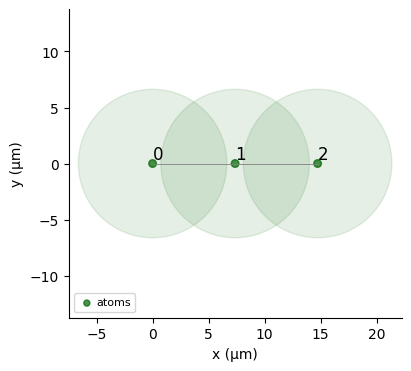

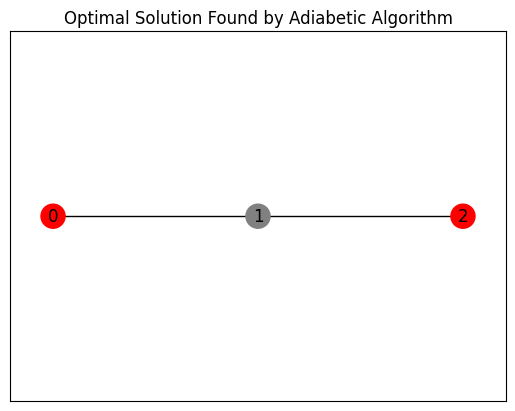

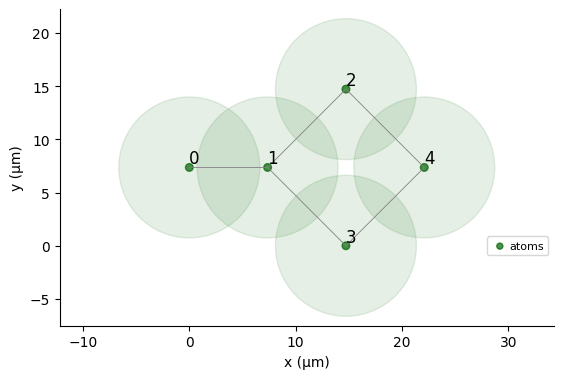

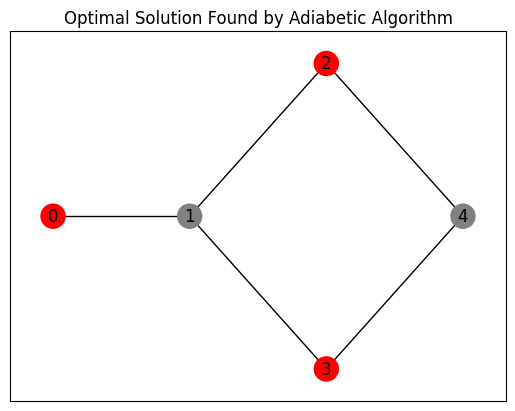

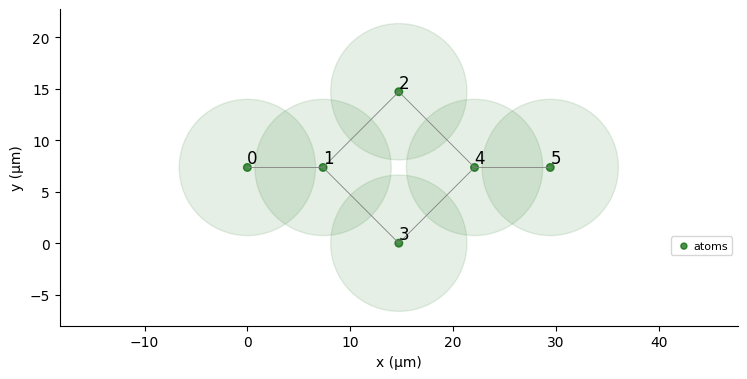

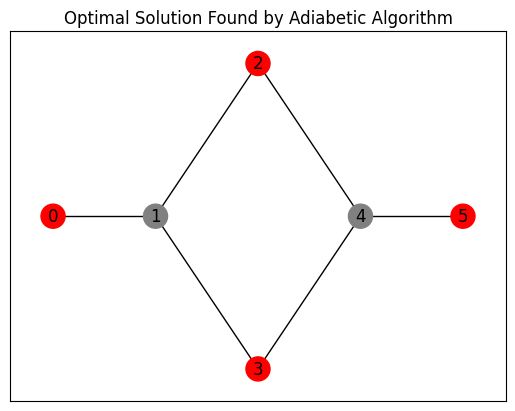

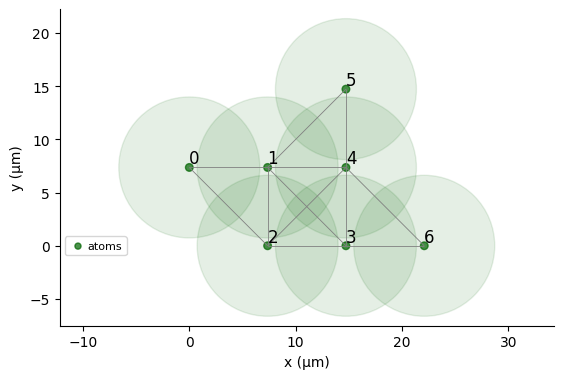

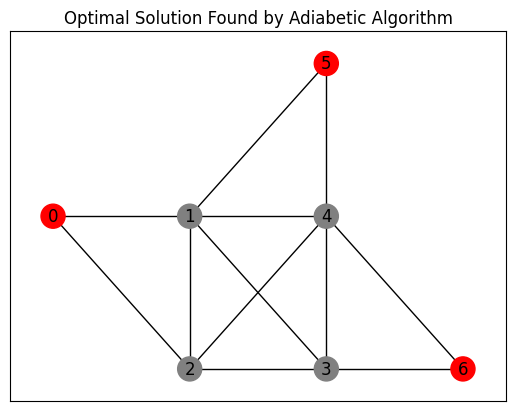

In [14]:
analog_results = []
for i in range(4):
    coords_scaled = [(i*scale,j*scale) for (i,j) in coordinate_list[i]]
    qubits = dict(enumerate(coords_scaled))
    reg = Register(qubits)
    reg.draw(
        blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
        draw_graph=True,
        draw_half_radius=True
    )
    adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
    )
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state(N_samples= 10000)
    validity = [MIS_obj(sol,G_set[i])[0] for sol in list(count_dict.keys())]

    analog_results.append(count_dict)
    solutions_sorted = sorted(count_dict.items(), key = lambda x: x[1], reverse= True)
    best_solution = ["Red" if i == "1" else "Grey" for i in solutions_sorted[0][0]]
    nx.draw_networkx(G_set[i], 
                    node_color = best_solution, 
                    with_labels = True, 
                    pos = coordinate_list[i])
    plt.title("Optimal Solution Found by Adiabetic Algorithm")
    plt.show()


### Result Comparison 

We want to compare two metrics, first, is the expected approximation ratio of the two solvers, and the probability of observing an MIS. 

In [15]:
analog_result_probs = []

for i, analog_result in enumerate(analog_results):
    keys,counts = zip(*analog_result.items())
    #counts to probs
    counts = np.array(counts)
    probs = counts/np.sum(counts)
    #append results
    analog_result_probs.append(dict(zip(keys,probs)))
result_table = []
for i, (analog_test_probs, qaoa) in enumerate(zip(analog_result_probs,QAOA_results)):
    qaoa_test_probs = qaoa['measurment outcomes'][0]
    analog_expected_MIS = np.sum([MIS_obj(x,G = G_set[i])[0]*MIS_obj(x,G = G_set[i])[1]*p
                        for x,p in analog_test_probs.items()])
    qaoa_expected_MIS = np.sum([MIS_obj(x[::-1],G = G_set[i])[0]*MIS_obj(x[::-1],G = G_set[i])[1]*p
                        for x,p in qaoa_test_probs.items()])
    best_MIS_value  = np.max([MIS_obj(x,G = G_set[i])[0]*MIS_obj(x,G = G_set[i])[1]
                        for x,p in analog_test_probs.items()])
    analog_prob_max = np.sum([p
                             if MIS_obj(x,G = G_set[i])[0]*MIS_obj(x,G = G_set[i])[1] == best_MIS_value
                                else 0
                            for x,p in analog_test_probs.items()])
    qaoa_prob_max   =  np.sum([p
                             if MIS_obj(x[::-1],G = G_set[i])[0]*MIS_obj(x[::-1],G = G_set[i])[1] == best_MIS_value
                                else 0
                            for x,p in qaoa_test_probs.items()])
    result_table.append([analog_expected_MIS/best_MIS_value, qaoa_expected_MIS/best_MIS_value, analog_prob_max, qaoa_prob_max])

### Final Results
Here we have the results between a run of the analog versus qaoa approaches. We see that analog outperforms qaoa across the 4 problem instances in both the approximation ratio, as well as the probability of finding the MIS solution(s). 

Even with just a baseline analog model, without optimzation in the seperation distances in the lattices, pulse time, or parametizing the omega and beta function, we get rather well results across the problem instances, and serve a high probability of measuring an MIS solution consistently. 

In [23]:
import pandas as pd
results = pd.DataFrame(result_table, 
             columns = ["R_analog", "R_qaoa", "P_MIS analog", "P_MIS qaoa"], 
             index = ["3","5","6","7"]).round(3)
results

,R_analog,R_qaoa,P_MIS analog,P_MIS qaoa
3,0.984,0.794,0.968,0.629
5,0.815,0.462,0.705,0.086
6,0.952,0.372,0.882,0.112
7,0.716,0.690,0.640,0.577


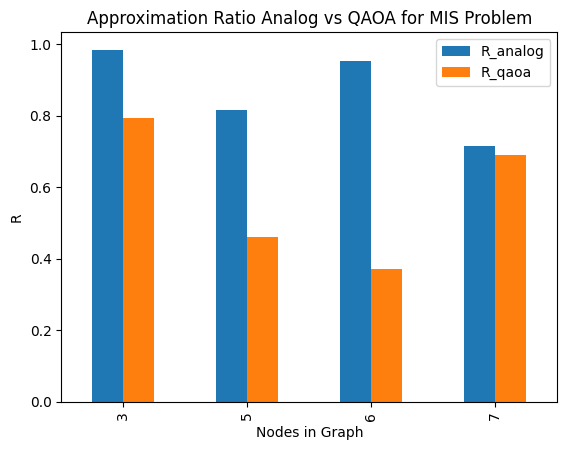

In [41]:
ax = results[["R_analog","R_qaoa"]].plot.bar()
ax.set_title("Approximation Ratio Analog vs QAOA for MIS Problem")
ax.set_ylabel("R")
ax.set_xlabel("Nodes in Graph")
plt.show()

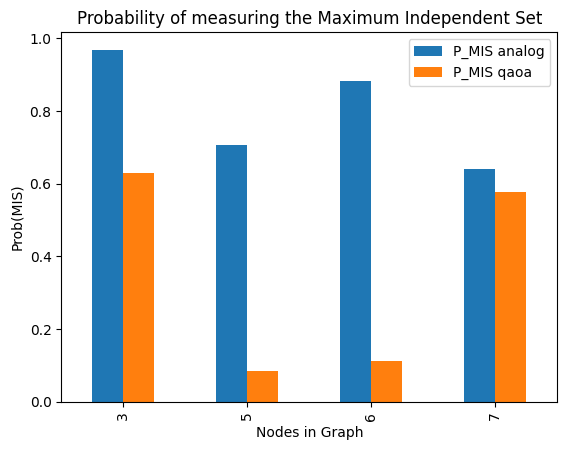

In [43]:
ax = results[["P_MIS analog","P_MIS qaoa"]].plot.bar()
ax.set_title("Probability of measuring the Maximum Independent Set")
ax.set_ylabel("Prob(MIS)")
ax.set_xlabel("Nodes in Graph")
plt.show()

# Some Reflections

Overall, this is a really cool oppurtunity to code out QAOA and the analoge solution. Several steps I'd take from here with more times are

For the QAOA circuit
1. Understand heuristics and/or approaches to optimize for gamma, beta and p values. While I used a solver SLSQPS, it does not seem obvious that the results are optimal. Sometimes when I run the optimizer multiple times, or start with different initial values, the optimizer returns a different set of parameters. Definitely as the circuit size increases, smarter approaches are necessary as cost of evaluating the cost function/ running the quantum circuits grows quickly. Furthermore, it is not obvious that these gamma and beta values can generalize to other graphs of the same size. It'd be of practical interest to have a model that can determine optimal gamma and beta values, or atleast a good prior, such as an ANN based model. 
2. Perhaps this is more analytically driven, but I am uncertain if the coefficients for my hamiltonian is appropiate. Perhaps a different set of H and J can produce different results, and the results observed is a consequence of poor hamiltonian formulation. I would appreciate guidance/feedback on whether my derivation from hamiltonian to quantum circuit is appropiate/correct. 

For the Analog circuit
1. I would like to take more time to think about how MIS can be generalized for a broader subset of graphs. In this formulation, I formualted the graphs such that it can easily map onto a square lattice. But for general graphs, with arbitary connections, I wonder what the algorithm is to map that network onto a 2-d Rydberg atomic array. 
2. I have no clear intuition into the pulse sequence setting. I do understand this is where value-add occurs, where companies like Q-ctrl or qBraid probably invest in optimized pulse sequences or control, taking into account of hardware constraints. I'd be curious to learn more about how/why different pulse functions can affect the quality of an adiabetic algorithm. 

In general and conclusion, I'm curious to try this problem, or QAOA and analog approaches on larger problem sizes, and with real hardwares. While I do have IBM education, I had issues with getting the Qiskit Runtime Services to run with the time I have for this project. Nevertheless, running of simulator proved rewarding. I am curious to see how my parameters/configuration stands up to real or realistic quantum errors. The results here are from a noise-free run and we'd probably see worse results on real hardware without any error-correction or prevention in place. 




